# Tarea 5: Clasificación de objetos usando CNNs

**Ignacio Zurita Tapia**

# Introducción

El presente informe tiene como por objetivo familiarizarse con herramientas de aprendizaje automático en python (en específico con el framework pytorch), mediante la creación de redes neuronales convolucionales a partir de ciertas especificaciones de arquitectura, para abordar un problema de clasificación de imágenes.

El dataset a utilizar corresponde a un fragmento del conjunto CIFAR10, el cual contiene imágenes de 32x32 pixeles, distribuidas en 10 clases. Así, para efectos de ésta tarea, los sets de entrenamiento, validación y prueba, corresponden a extractos 10000 imágenes cada uno.

Con esto, se procede a enumerar las principales secciones del informe:

- Lectura del dataset: Una vez descargado los archivos, éstos son leídos y almacenados en un objeto compatible con pytorch, a modo de facilitar el posterior entrenamiento.

- Implementación red grande: Se implementa, entrena y evalúa una de las arquitecturas especificadas.
- Implementación red pequeña: Se implementa, entrena y evalúa la segunda arquitectura pedida.
- Resutados: Se comparan los rendimientos de ambas arquitecturas implementadas.
- Conclusiones



# Descarga y descompresión de dataset



In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-12-15 01:32:02--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  88.8MB/s    in 1.8s    

2020-12-15 01:32:04 (88.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [2]:
!tar -xf /content/cifar-10-python.tar.gz

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle
import matplotlib.pyplot as plt

# Lectura del dataset

En primer lugar, para abrir los archivos del dataset, se tiene la función *unpickle*, la cual lee y retorna el diccionario correspondiente al archivo de entrada.

Luego, para crear los dataset de entrenamiento, validación y prueba, se crean las clases CIFAR10 Train/Val/Test las cuales heredan de la clase Dataset del paquete torch.utils.data. De esta forma cada una de las clases, en su constructor lee el archivo respectivo, como se lista a continuación:

- Train: data_batch_1
- Val: data_batch_2
- Test: test_batch

Así, guarda en los atributos *images* y *labels*, todas las imágenes y etiquetas, respectivamente, de ese batch. 

Además, en cada caso, se reescalan las imágenes para que queden en el rango [-1,1], mediante la siguiente transformación:

$$ I_t = I_o\frac{2}{255} - 1$$

con $I_t$ la imagen transformada, e $I_o $ la imagen original.

Cabe destacar además, que cada imagen en el dataset viene en forma de vector de largo $W\cdot H\cdot C$, donde $W=32$ es el ancho, $H=32$ el largo y $C=3$ el número de canales de la imagen, por lo que es necesario hacer un reshape para que las imágenes queden de dimensiones (3,32,32).

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='latin1')
    return dictionary

In [5]:
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

class CIFAR10Train(Dataset):
  def __init__(self, path):
    dictionary = unpickle(path + 'data_batch_1')
    self.images = dictionary['data']
    self.images = self.images.reshape(-1,3,32,32)
    self.images = (torch.Tensor(self.images)*2)/255 -1
    
    #images = images.movedim(1,3)
    self.labels = dictionary['labels']

  def __len__(self):
    return self.images.shape[0]
 
  def __getitem__(self, index):
    return self.labels[index], self.images[index]

class CIFAR10Val(Dataset):
  def __init__(self, path):
    dictionary = unpickle(path + 'data_batch_2')
    self.images = dictionary['data']
    self.images = self.images.reshape(-1,3,32,32)
    self.images = (torch.Tensor(self.images)*2)/255 -1
    
    #images = images.movedim(1,3)
    self.labels = dictionary['labels']

  def __len__(self):
    return self.images.shape[0]
 
  def __getitem__(self, index):
    return self.labels[index], self.images[index]

class CIFAR10Test(Dataset):
  def __init__(self, path):
    dictionary = unpickle(path + 'test_batch')
    self.images = dictionary['data']
    self.images = self.images.reshape(-1,3,32,32)
    self.images = (torch.Tensor(self.images)*2)/255 -1
    
    #images = images.movedim(1,3)
    self.labels = dictionary['labels']

  def __len__(self):
    return self.images.shape[0]
 
  def __getitem__(self, index):
    return self.labels[index], self.images[index]


Se crean los distintos conjuntos y a partir de ellos se generan los dataloaders, los cuales son objetos iterables que permiten su lectura por batches, que en este caso son de tamaño 32.




In [6]:
from torch.utils.data import DataLoader, random_split
batch_size = 32
dataset_train = CIFAR10Train('/content/cifar-10-batches-py/')
dataset_val = CIFAR10Val('/content/cifar-10-batches-py/')
dataset_test = CIFAR10Test('/content/cifar-10-batches-py/')

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Red grande

Se crea la red grande a partir de la arquitectura especificada en el enunciado, considerando que se agregó una capa Flatten a la entrada de la primera capa fully conected, ya que la capa previa retornaba un tensor de dimensiones [B, 512, 2, 2], donde B es el tamaño del batch.

In [7]:
class MyNetBig(nn.Module):

  def __init__(self, nclasses):
    super(MyNetBig, self).__init__()

    self.nclasses = nclasses
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
    self.conv1_2 = nn.Conv2d(64, 64, 3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv2_2 = nn.Conv2d(128, 128, 3, padding = 1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv3_2 = nn.Conv2d(256, 256, 3, padding = 1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding = 1)
    self.conv4_2 = nn.Conv2d(512, 512, 3, padding = 1)
    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(128)
    self.bn3 = torch.nn.BatchNorm2d(256)
    self.bn4 = torch.nn.BatchNorm2d(512)
    
    self.bn1_2 = torch.nn.BatchNorm2d(64)
    self.bn2_2 = torch.nn.BatchNorm2d(128)
    self.bn3_2 = torch.nn.BatchNorm2d(256)
    self.bn4_2 = torch.nn.BatchNorm2d(512)

    self.maxpool = torch.nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(2048,128)
    self.bn5 = torch.nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(128, 256)
    self.bn6 = torch.nn.BatchNorm1d(256)
    self.fc3 = nn.Linear(256, 512)
    self.bn7 = torch.nn.BatchNorm1d(512)
    self.fc4 = nn.Linear(512, 1024)
    self.bn8 = torch.nn.BatchNorm1d(1024)
    self.fc5 = nn.Linear(1024, self.nclasses)
    self.softmax = nn.Softmax(dim=1)
    self.flatten = nn.Flatten()
     
  def forward(self, x):
   
    x = self.bn1(self.relu(self.conv1(x)))
    x = self.bn1_2(self.relu(self.conv1_2(x)))
    x = self.maxpool(x)
    x = self.bn2(self.relu(self.conv2(x)))
    x = self.bn2_2(self.relu(self.conv2_2(x)))
    x = self.maxpool(x)
    x = self.bn3(self.relu(self.conv3(x)))
    x = self.bn3_2(self.relu(self.conv3_2(x)))
    x = self.maxpool(x)
    x = self.bn4(self.relu(self.conv4(x)))
    x = self.bn4_2(self.relu(self.conv4_2(x)))
    x = self.maxpool(x)
    x = self.bn5(self.relu(self.fc1(self.flatten(x))))
    x = self.bn6(self.relu(self.fc2(x)))
    x = self.bn7(self.relu(self.fc3(x)))
    x = self.bn8(self.relu(self.fc4(x)))
    x = self.fc5(x)
    return x

A continuación, podemos observar un resumen de la red, la cual coincide con lo esperado

In [8]:
from torchsummary import summary
net = MyNetBig(10)
summary(net.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,584
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        MaxPool2d-14            [-1, 12

## Entrenamiento

Se crea la función *train*, la cual recibe una red neuronal, el número de épocas, y los conjuntos de entrenamiento y validación. Esta función se encarga de entrenar la red entregada a partir de los datos de entrenamiento, y además de registrar el historial de métricas (accuracy y función de costo) al final de cada época para el conjunto de validación, las cuales serán retornadas junto al tiempo total de entrenamiento. 

In [9]:
import sys
import time
import numpy as np
def train(net, n_epochs, train_loader, val_loader):
  total_train = len(train_loader)*train_loader.batch_size
  total_val = len(val_loader)*val_loader.batch_size
  val_acc = []
  val_loss = []
  t0 = time.time()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  for epoch in range(n_epochs):
    net.train()
    running_loss, running_acc = 0.0, 0.0
    for i, data in enumerate(train_loader, 0): # Obtener batch
      labels = data[0].cuda()
      inputs = data[1].float().cuda()
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # Calcular accuracy sobre el conjunto de validación y almacenarlo
      # para hacer un plot después


      items = (i+1) * train_loader.batch_size
      running_loss += loss.item()
      max_prob, max_idx = torch.max(outputs.data, dim=1)
      running_acc += torch.sum(max_idx == labels).item()
      info = f'\rEpoch:{epoch+1}({items}/{total_train}), '
      info += f'Loss:{running_loss/items:02.5f}, '
      info += f'Train Acc:{running_acc/items*100:02.1f}%'
      sys.stdout.write(info)

    net.eval()
    running_acc = 0.0
    valid_loss = 0.0
    
    for i, data in enumerate(val_loader, 0):
      labels = data[0].cuda()
      inputs = data[1].float().cuda()
      with torch.no_grad():
        Y_pred = net(inputs)
      max_prob, max_idx = torch.max(Y_pred.data, dim=1)
      running_acc += torch.sum(max_idx == labels).item()
      loss = criterion(Y_pred, labels)
      # record validation loss
      valid_loss+= loss.item()

    val_acc.append(running_acc/total_val*100)  
    val_loss.append(valid_loss/total_val*100)  
    info = f', Val Acc:{running_acc/total_val*100:02.2f}%.\n'
    sys.stdout.write(info)
  t1 = time.time()
  return val_acc, val_loss, t1-t0
    

Se instancia la red grande y se pasa a la gpu, luego se entrena durante 40 épocas:

In [10]:
big_net = MyNetBig(10)
big_net.cuda()
n_epochs = 40
big_net_val_acc, big_net_val_loss, big_net_tiempo = train(big_net, n_epochs, train_loader, val_loader)

Epoch:1(10016/10016), Loss:0.06024, Train Acc:30.8%, Val Acc:40.01%.
Epoch:2(10016/10016), Loss:0.04873, Train Acc:43.7%, Val Acc:48.60%.
Epoch:3(10016/10016), Loss:0.04217, Train Acc:51.5%, Val Acc:54.73%.
Epoch:4(10016/10016), Loss:0.03794, Train Acc:56.8%, Val Acc:60.95%.
Epoch:5(10016/10016), Loss:0.03479, Train Acc:61.3%, Val Acc:60.04%.
Epoch:6(10016/10016), Loss:0.03054, Train Acc:65.7%, Val Acc:63.28%.
Epoch:7(10016/10016), Loss:0.02574, Train Acc:71.8%, Val Acc:67.27%.
Epoch:8(10016/10016), Loss:0.02267, Train Acc:75.2%, Val Acc:69.30%.
Epoch:9(10016/10016), Loss:0.01885, Train Acc:79.3%, Val Acc:70.43%.
Epoch:10(10016/10016), Loss:0.01532, Train Acc:83.1%, Val Acc:70.13%.
Epoch:11(10016/10016), Loss:0.01372, Train Acc:85.3%, Val Acc:70.13%.
Epoch:12(10016/10016), Loss:0.01036, Train Acc:88.6%, Val Acc:71.50%.
Epoch:13(10016/10016), Loss:0.00889, Train Acc:90.5%, Val Acc:72.99%.
Epoch:14(10016/10016), Loss:0.00716, Train Acc:92.2%, Val Acc:72.56%.
Epoch:15(10016/10016), Loss:0

Como se puede ver, la red alcanzó un máximo de 74.57% de accuracy en el conjunto de validación en la época 36. Finalmente, para la última época, se obtuvo un accuracy de 71.16% en validación, mientras que para el conjunto de entrenamiento, se alcanzó un 98.3%, es decir cerca de un 30% de diferencia. Esto claramente nos indica que la red está sobre ajustada al conjunto de entrenamiento.

## Gráficos del historial de entrenamiento

In [11]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})

A continuación, podemos observar el accuracy y loss durante el entrenamiento, para el conjunto de validación.

Como podemos ver, el accuracy se empieza a estabilizar aproximadamente en la época 15, observando un comportamiento extraño en la función de costos, ya que alcanza su mínimo en la época 8 y luego crece incluso superando su valor en la primera época, a pesar de que el accuracy no varíe demasiado.

Text(0, 0.5, 'Loss')

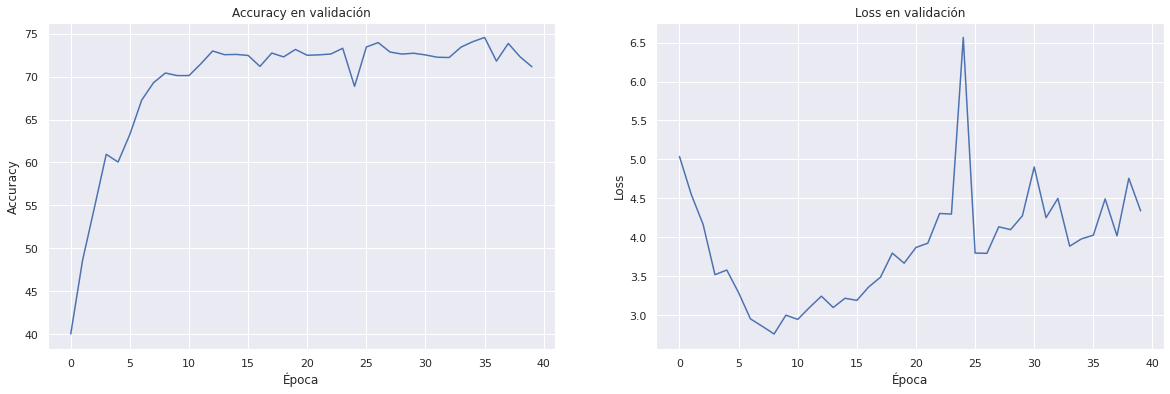

In [12]:
fig, axs = plt.subplots(1,2)
axs[0].plot(big_net_val_acc)
axs[0].set_title('Accuracy en validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Accuracy')
axs[1].plot(big_net_val_loss)
axs[1].set_title('Loss en validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Loss')

# Red pequeña

A continuación se muestra la creación de la red pequeña, la cual cumple con la arquitectura requerida:

In [18]:
class MyNetSmall(nn.Module):

  def __init__(self, nclasses):
    super(MyNetSmall, self).__init__()

    self.nclasses = nclasses
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv4 = nn.Conv2d(256, 512, 3, padding = 1)
    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(128)
    self.bn3 = torch.nn.BatchNorm2d(256)
    self.bn4 = torch.nn.BatchNorm2d(512)
    self.maxpool = torch.nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(2048,128)
    self.bn5 = torch.nn.BatchNorm1d(128,)
    self.fc2 = nn.Linear(128, self.nclasses)
    self.softmax = nn.Softmax()
    self.flatten = nn.Flatten()
     
  def forward(self, x):
    x = self.bn1(self.relu(self.conv1(x)))
    x = self.maxpool(x)
    x = self.bn2(self.relu(self.conv2(x)))
    x = self.maxpool(x)
    x = self.bn3(self.relu(self.conv3(x)))
    x = self.maxpool(x)
    x = self.bn4(self.relu(self.conv4(x)))
    x = self.maxpool(x)
    x = self.bn5(self.relu(self.fc1(self.flatten(x))))
    x = self.fc2(x)
    return x

In [19]:
from torchsummary import summary

small_net = MyNetSmall(10)
small_net.cuda()
summary(small_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
             ReLU-10            [-1, 256, 8, 8]               0
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
             ReLU-14            [-1, 51

Entrenamos la red utilizando la función *train* previamente creada:

In [20]:
n_epochs = 40
small_net_val_acc, small_net_val_loss, small_net_tiempo = train(small_net, n_epochs, train_loader, val_loader)

Epoch:1(10016/10016), Loss:0.04789, Train Acc:43.5%, Val Acc:52.07%.
Epoch:2(10016/10016), Loss:0.03689, Train Acc:57.7%, Val Acc:60.36%.
Epoch:3(10016/10016), Loss:0.02832, Train Acc:68.5%, Val Acc:65.33%.
Epoch:4(10016/10016), Loss:0.02611, Train Acc:70.4%, Val Acc:59.43%.
Epoch:5(10016/10016), Loss:0.02055, Train Acc:77.2%, Val Acc:69.02%.
Epoch:6(10016/10016), Loss:0.01154, Train Acc:87.7%, Val Acc:67.76%.
Epoch:7(10016/10016), Loss:0.00716, Train Acc:92.3%, Val Acc:68.32%.
Epoch:8(10016/10016), Loss:0.00452, Train Acc:95.3%, Val Acc:68.48%.
Epoch:9(10016/10016), Loss:0.00410, Train Acc:95.5%, Val Acc:67.88%.
Epoch:10(10016/10016), Loss:0.00454, Train Acc:95.0%, Val Acc:58.09%.
Epoch:11(10016/10016), Loss:0.00790, Train Acc:91.5%, Val Acc:67.36%.
Epoch:12(10016/10016), Loss:0.00199, Train Acc:97.9%, Val Acc:68.95%.
Epoch:13(10016/10016), Loss:0.00094, Train Acc:99.0%, Val Acc:69.60%.
Epoch:14(10016/10016), Loss:0.00086, Train Acc:99.1%, Val Acc:70.06%.
Epoch:15(10016/10016), Loss:0

Graficamos accuracy y loss durante el entrenamiento, para el conjunto de validación:

Text(0, 0.5, 'Loss')

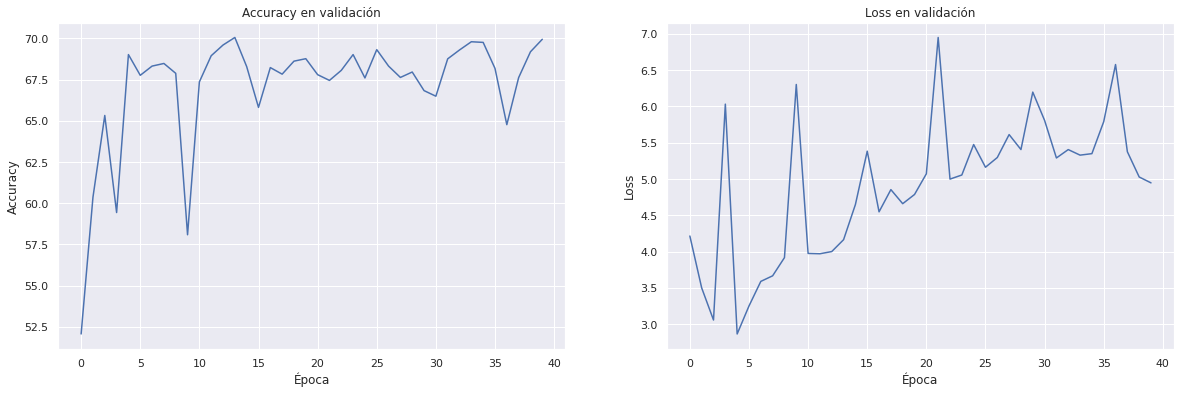

In [21]:
fig, axs = plt.subplots(1,2)
axs[0].plot(small_net_val_acc)
axs[0].set_title('Accuracy en validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Accuracy')
axs[1].plot(small_net_val_loss)
axs[1].set_title('Loss en validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Loss')

Como se puede observar de los gráicos, el entrenamiento de esta red, parece ser un poco más inestable que la anterior, puesto que se observan grandes saltos tanto para el accuracy como para el loss.

# Resultados

En cuanto a los tiempos de entrenamiento, por un lado, para la red grande, éste fue de aproximadamente 5 minutos, mientras que para la red pequeña fue cercano a 2 minutos y 50 segundos. Es decir, la red pequeña fue un 180% más rápida que la red big, la cual tenía el triple de parámetros entrenables.

In [73]:
print('Tiempo de entrenamiento red Big (40 épocas): ', big_net_tiempo/60, ' minutos')

Tiempo de entrenamiento red Big (40 épocas):  5.032377906640371  minutos


In [74]:
print('Tiempo de entrenamiento Small (40 épocas): ', small_net_tiempo/60, ' minutos')

Tiempo de entrenamiento Small (40 épocas):  2.7918575247128805  minutos


A continuación, se define la función *evaluar*, la cual recibe una red y un dataloader y entrega el accuracy obtenido para ese conjunto de datos.

In [ ]:
def evaluar(net, data_loader):
  net.eval()
  running_acc = 0.0
  valid_loss = 0.0
  total_test = len(data_loader)*data_loader.batch_size
  criterion = nn.CrossEntropyLoss()
  for i, data in enumerate(test_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    with torch.no_grad():
      Y_pred = net(inputs)
    max_prob, max_idx = torch.max(Y_pred.data, dim=1)
    running_acc += torch.sum(max_idx == labels).item()
    loss = criterion(Y_pred, labels)
    # record validation loss
    valid_loss+= loss.item()

  #val_acc.append(running_acc/total_val*100)  
  info = f'Val Acc:{running_acc/total_test*100:02.2f}%.\n'
  sys.stdout.write(info)
  return running_acc/total_test*100

Evaluamos ambas redes sobre el conjunto de prueba, como podemos ver, la red Big alcanzó un 71.34% de accuracy, mientras que la Small un 70.58%.

In [ ]:
big_net_acc_test = evaluar(big_net, test_loader)

Val Acc:71.34%.


In [23]:
small_net_acc_test = evaluar(small_net, test_loader)

Val Acc:70.58%.


Se procede a obtener las matrices de confusión sobre el conjunto de prueba, para esto, se itera sobre el dataloader y se guardan las predicciones de ambas redes:

In [52]:
big_pred = []
small_pred = []
y_true = []
for batch in test_loader:
  labels = batch[0].cuda()
  inputs = batch[1].float().cuda()
  with torch.no_grad():
    pred_1 = big_net(inputs)
    pred_2 = small_net(inputs)
  max_prob_1, max_idx_1 = torch.max(pred_1.data, dim=1)
  big_pred.extend(max_idx_1)
  max_prob_2, max_idx_2 = torch.max(pred_2.data, dim=1)
  small_pred.extend(max_idx_2)
  y_true.extend(labels)

Se calculan las matrices de confusión:

In [56]:
from sklearn.metrics import confusion_matrix
cf_mtrx_big = confusion_matrix(torch.Tensor(y_true), torch.Tensor(big_pred), normalize = 'true')
cf_mtrx_small = confusion_matrix(torch.Tensor(y_true), torch.Tensor(small_pred), normalize = 'true')

**Matriz de confusión conjunto de prueba, red Big**

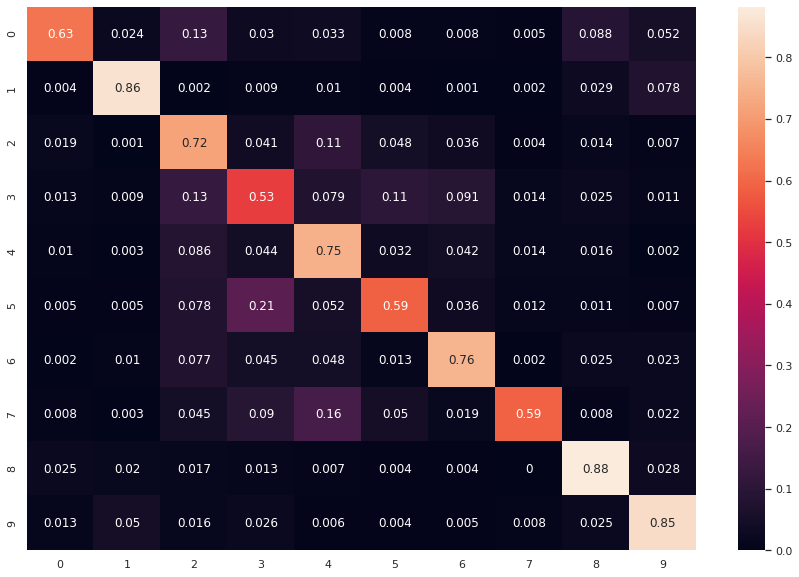

In [77]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(cf_mtrx_big, annot=True)

**Matriz de confusión conjunto de prueba, red Small**

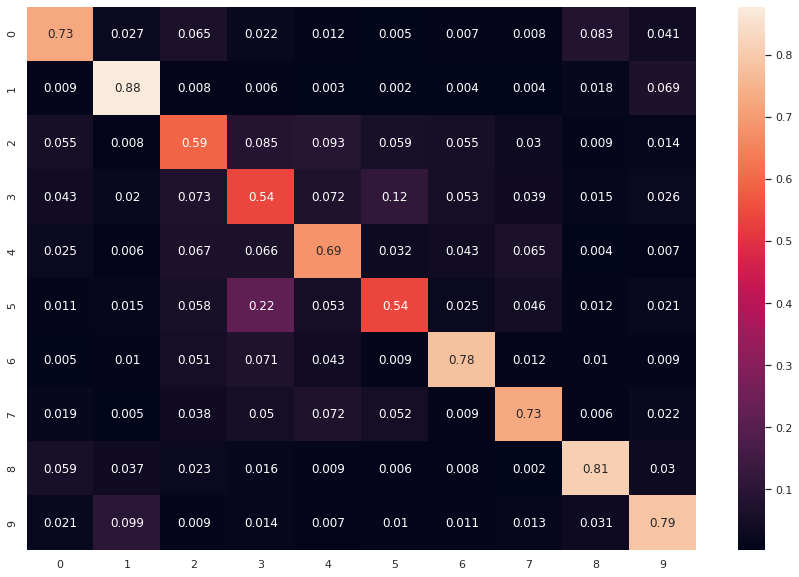

In [78]:
sns.heatmap(cf_mtrx_small, annot=True)

Como podemos observar, ambas redes comparten un par de clases (3 y 5) en las que suelen equivocarse más, lo que puede indicar que pueden ser más difíciles de aprender.

A partir de las diferentes métricas se puede decir que la red Big obtuvo mejores resultados en general, ya que alcanzó un mejor accuracy y su entrenamiento fue más estable que la red Small. A pesar de esto, la diferencia entre ambas en términos de ésta métrica no es muy grande (1%). 
Por otro lado, el entrenamiento dela red Small es practicamente 2 veces rápido, lo que se puede considerar un plus si se requiere una implementación básica como baseline.

Finalmente, se puede decir que las arquitecturas utilizadas no son del todo buenas para ésta aplicación o dataset, dado sus bajos rendimientos en relación al estado del arte que actualmente está sobre el 99% de accuracy.


# Conclusiones

En el presente informe se lograron implementar 2 arquitecturas diferentes de CNNs en el framework Pytorch, para luego, entrenarlas sobre particiones del dataset CIFAR10. En base a esto, se pudo comparar ambas redes, en términos de accuracy y tiempo de entrenamiento, llegando a que ninguna de las dos consigió resultados cercanos a los modelos de clasificación de imágenes más avanzados hasta el momento.

Del trabajo realizado, se pudieron refrescar los conocimientos previos en el framework Pytorch, el cual es uno de los más reconocidos para tareas de Machine Learning. Además, se pudo aplicar la teoría vista en clases para la implementación de redes convolucionales en el área de procesamiento de imágenes.

Las principales dificultades encontradas, tienen que ver con la implementación de las redes en Pytorch, ya que, en principio se estaba cometiendo el error de utilizar más de una vez las capas definidas en el constructor de la red (en específico las de batch normalization para la red Big), lo cual arrojaba resultados muy malos a la hora de evaluar el modelo.

Los resultados son bastante buenos considerando la simplicidad de las redes implementadas, las cuales no ocupan algunos recursos actuales que han demostrado dar buenos resultados, como dropout para regularización, bloques residuales o bloques en paralelo como los de Resnet o Inception.

Otra posible forma de mejorar los resultados sin modificar las arquitecturas, podría ser variando los hiperparámetros como la tasa de aprendizaje, cantidad de épocas, tamaño del batch o también, utilizando el dataset completo de entrenamiento.